In [1]:
import os

import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

import matplotlib.pyplot as plt
from PIL import Image

from RAVDESS_dataset_util import *
from EmoClassCNN import *
from MVAE import *

torch.set_default_dtype(torch.float64)

pyro.enable_validation(False)

In [2]:
folder_path = '/home/studenti/ballerini/datasets/RAVDESS_frames_ds'

In [3]:
img_size = 64
batch_size = 16
num_classes = len(emocat)

face_dataset = FaceEmotionDataset(root_dir=folder_path,
                                    transform=transforms.Compose([
                                        Rescale(img_size), 
                                        CenterCrop(img_size), 
                                        ToTensor()
                                    ]))        

trainingset_len = len(face_dataset) // 100 * 90
testset_len = len(face_dataset) - trainingset_len

print('training set size: ', trainingset_len)
print('test set size: ', testset_len)

train_set, test_set = torch.utils.data.random_split(face_dataset, 
                                                    [trainingset_len, testset_len], 
                                                    #generator=torch.Generator().manual_seed(42)
                                                   )
                                                    
                                                    
dataset_loader = DataLoader(train_set, batch_size=batch_size,
                        shuffle=True, num_workers=20)

testset_loader = DataLoader(train_set, batch_size=batch_size,
                        shuffle=True, num_workers=20)

print(len(face_dataset))

training set size:  8820
test set size:  1047
9867


(64, 64, 3)


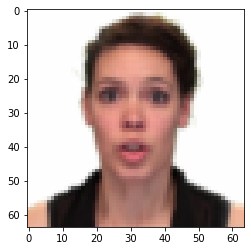

In [4]:
img = np.array(next(iter(face_dataset))['image']).transpose((1, 2, 0))
print(img.shape)
plt.imshow(img)

In [5]:
def emotion_rating_conversion(cat):
    ratings = torch.zeros(num_classes)
    ratings[cat] = 1
    return ratings

In [6]:
import gc

gc.collect()
torch.cuda.empty_cache()
pyro.clear_param_store()

class Args:
    
    learning_rate = 1e-5
    weight_decay = 1e-6
    num_epochs = 35
    z_dim = 128
    ch_size = 16
    
    emotion_dim = num_classes
    img_size = img_size
    seed = 30
    cuda = True
    
args = Args()

# setup the optimizer
adam_args = {"lr": args.learning_rate}#, "weight_decay":args.weight_decay}
optimizer = Adam(adam_args)

# setup the VAE
mvae = MVAE(z_dim=args.z_dim, 
            emotion_dim = args.emotion_dim,
            img_size=args.img_size, 
            use_cuda=args.cuda,
            ch_size=args.ch_size)

# setup the inference algorithm
svi = SVI(mvae.model, mvae.guide, optimizer, loss=Trace_ELBO())

In [ ]:
from tqdm import tqdm

train = True
savemodel = False

if train:
    train_elbo = []
    test_elbo = []
    # training loop
    for epoch in tqdm(range(args.num_epochs)):
        epoch_loss = 0.
        for batch_num, sample in enumerate(dataset_loader):

            faces, emotions = sample['image'], sample['cat']
            emotions = torch.stack([emotion_rating_conversion(emo) for emo in emotions])

            # if on GPU put mini-batch into CUDA memory
            if args.cuda:
                faces, emotions = faces.cuda(), emotions.cuda()

            # do ELBO gradient and accumulate loss
            epoch_loss += svi.step(images=faces, emotions=emotions)
            epoch_loss += svi.step(images=faces, emotions=None)
            epoch_loss += svi.step(images=None, emotions=emotions)

        # report training diagnostics
        normalizer_train = len(dataset_loader)
        total_epoch_loss_train = epoch_loss / normalizer_train
        train_elbo.append(total_epoch_loss_train)

        # report training diagnostics
        print("average training loss: %.4f" % (total_epoch_loss_train))
    plt.plot(train_elbo)
else:
    pyro.get_param_store().load('trained_models/mvae_pretrained.save')
    pyro.module("mvae", mvae, update_module_params=True)

if savemodel:
        if not os.path.exists('./trained_models'):
          os.mkdir('./trained_models')
        pyro.get_param_store().save('trained_models/mvae_pretrained.save')

  3%|██▋                                                                                           | 1/35 [02:04<1:10:43, 124.80s/it]

average training loss: 4988445.4068


  6%|█████▎                                                                                        | 2/35 [04:17<1:11:04, 129.23s/it]

average training loss: 4406508.6357


  9%|████████                                                                                      | 3/35 [06:27<1:09:15, 129.87s/it]

average training loss: 3859789.7987


In [ ]:
num_samples = 4
input_array = np.zeros(shape=(img_size, 1, 3), dtype="uint8")
reconstructed_array = np.zeros(shape=(img_size, 1, 3), dtype="uint8")
    
# pick NUM_SAMPLES random test images from the first mini-batch and
# visualize how well we're reconstructing them

faces = next(iter(dataset_loader))['image']
if args.cuda:
    faces = faces.cuda()

reco_indices = np.random.randint(0, faces.size(0), num_samples)
for index in reco_indices:
    input_img = faces[index, :]
    # storing the input image
    input_img_display = np.array(input_img.cpu()*255., dtype='uint8')
    input_img_display = input_img_display.transpose((1, 2, 0))
    input_array = np.concatenate((input_array, input_img_display), axis=1)

    # generating the reconstructed image and adding to array
    input_img = input_img.view(1, 3, img_size, img_size)
    reconstructed_img = mvae.reconstruct_img_nosample(input_img)
    reconstructed_img = reconstructed_img.cpu().view(3, img_size, img_size).detach().numpy()
    reconstructed_img = np.array(reconstructed_img*255., dtype='uint8')
    reconstructed_img = reconstructed_img.transpose((1, 2, 0))
    reconstructed_array = np.concatenate((reconstructed_array, reconstructed_img), axis=1)


from PIL import Image
# remove first, blank column, and concatenate
input_array = input_array[:,1:,:]
reconstructed_array = reconstructed_array[:,1:,:]
display_array = np.concatenate((input_array, reconstructed_array), axis=0)
plt.imshow(display_array)

In [ ]:
def testBatch(model, dataset_loader, categories):
    sample = next(iter(dataset_loader))
    images = sample['image']
    labels = sample['cat']
    if args.cuda:
        images = images.cuda()
        labels = labels.cuda()

    imageshow(torchvision.utils.make_grid(images))

    batch_size = len(labels)

    # Show the real labels on the screen 
    print('Real labels:', '\t'.join('%5s' % categories[labels[j].item()] for j in range(batch_size)))

    predicted = []
    for image in images:
        output = model.emotion_classifier(input_img)
        predicted.append(torch.argmax(output, 1))

    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted:', '\t'.join('%5s' % categories[predicted[j].item()] for j in range(batch_size)))

In [ ]:
testBatch(mvae, testset_loader, emocat)